# **Imoports**

In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import cv2
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import os
import glob
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import shap
from captum.attr import IntegratedGradients, Saliency, DeepLift, GuidedBackprop

# **Dataset Prepration**

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, image_dir):
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, "*.png")))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (112, 112))
        image = image.astype(np.float32) / 255.0
        image = np.stack([image, image, image], axis=0)  
        label = 1  
        
        return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [25]:
train_dataset = ImageDataset("G:/XAI/preprocessed_images/train_images")
val_dataset = ImageDataset("G:/XAI/preprocessed_images/val_images")

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


# **Define & Train the Model**

In [ ]:
class DenseNet121Model(nn.Module):
    def __init__(self, num_classes=1):
        super(DenseNet121Model, self).__init__()
        self.densenet = models.densenet121(pretrained=True)
        self.densenet.classifier = nn.Linear(self.densenet.classifier.in_features, num_classes)

    def forward(self, x):
        return self.densenet(x)

model = DenseNet121Model(num_classes=1)

c:\Users\yosef\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yosef\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
criterion = nn.BCEWithLogitsLoss()  
optimizer = optim.Adam(model.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121Model(num_classes=1).to(device)

def compute_accuracy(preds, labels):
    return (preds == labels).sum().item() / len(labels)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)  
        outputs = outputs.view(-1)
        labels = labels.view(-1)  
        loss = criterion(outputs, labels.float())  
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        preds = torch.sigmoid(outputs) > 0.5
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            outputs = outputs.view(-1) 
            
            labels = labels.view(-1)  
            
            loss = criterion(outputs, labels.float())
            
            val_loss += loss.item()
            
            preds = torch.sigmoid(outputs) > 0.5
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    val_loss /= len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    
    print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")


Epoch [1/10]
  Train Loss: 0.4355, Train Accuracy: 92.54%
  Val Loss: 0.4420, Val Accuracy: 90.88%
Epoch [2/10]
  Train Loss: 0.4362, Train Accuracy: 92.24%
  Val Loss: 0.4067, Val Accuracy: 93.36%
Epoch [3/10]
  Train Loss: 0.4367, Train Accuracy: 91.82%
  Val Loss: 0.4492, Val Accuracy: 89.79%
Epoch [4/10]
  Train Loss: 0.4360, Train Accuracy: 91.84%
  Val Loss: 0.4263, Val Accuracy: 90.88%
Epoch [5/10]
  Train Loss: 0.4362, Train Accuracy: 92.14%
  Val Loss: 0.4445, Val Accuracy: 90.78%
Epoch [6/10]
  Train Loss: 0.4353, Train Accuracy: 92.07%
  Val Loss: 0.4473, Val Accuracy: 89.10%
Epoch [7/10]
  Train Loss: 0.4366, Train Accuracy: 91.67%
  Val Loss: 0.4245, Val Accuracy: 91.58%
Epoch [8/10]
  Train Loss: 0.4353, Train Accuracy: 91.74%
  Val Loss: 0.3984, Val Accuracy: 93.86%
Epoch [9/10]
  Train Loss: 0.4357, Train Accuracy: 91.87%
  Val Loss: 0.4293, Val Accuracy: 91.48%
Epoch [10/10]
  Train Loss: 0.4356, Train Accuracy: 92.31%
  Val Loss: 0.4605, Val Accuracy: 88.31%


In [48]:
#Save Trained Model
torch.save(model.state_dict(), "densenet121_model.pth")
model.load_state_dict(torch.load("densenet121_model.pth"))
model.eval()

DenseNet121Model(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mo

# **XAI Techniques**

In [49]:
val_iter = iter(val_loader)
inputs, labels = next(val_iter)
test_image = inputs[0:1].to(device)
test_image_np = test_image.cpu().numpy().transpose(0, 2, 3, 1)[0] * 255

## **Grad-CAM**

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        def hook_fn_forward(module, input, output):
            self.activations = output
            
        def hook_fn_backward(module, grad_input, grad_output):
            self.gradients = grad_output[0]
        
        target_layer.register_forward_hook(hook_fn_forward)
        target_layer.register_backward_hook(hook_fn_backward)
    
    def __call__(self, x):
        x.requires_grad_()  # Enable gradients for input
        self.model.zero_grad()
        output = self.model(x)
        
        score = output[0]
        score.backward()
        
        gradients = self.gradients
        activations = self.activations
        
        weights = torch.mean(gradients, dim=[2, 3])
        cam = torch.sum(weights[:, :, None, None] * activations, dim=1)
        
        cam = F.relu(cam)
        cam = F.interpolate(cam.unsqueeze(1), size=(112, 112), mode='bilinear', align_corners=False)
        cam = cam.squeeze()
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        
        return cam.detach().cpu().numpy()

target_layer = model.densenet.features.denseblock4
grad_cam = GradCAM(model, target_layer)
cam_output = grad_cam(test_image)

## **integrated gradients explanation**

In [ ]:
def integrated_gradients_explanation(model, input_image):
    ig = IntegratedGradients(model)
    input_image.requires_grad_()
    
    attributions = ig.attribute(input_image, target=0, n_steps=50)
    attributions = torch.mean(attributions, dim=1)
    
    attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min())
    
    return attributions.detach().cpu().numpy()

ig_output = integrated_gradients_explanation(model, test_image)

## **Deep Lift**

In [ ]:
def deeplift_explanation(model, input_image):
    deep_lift = DeepLift(model)
    input_image.requires_grad_()
    attributions = deep_lift.attribute(input_image, target=0)
    attributions = torch.mean(attributions, dim=1)    
    attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min())    
    
    return attributions.detach().cpu().numpy()

deeplift_output = deeplift_explanation(model, test_image)

c:\Users\yosef\anaconda3\Lib\site-packages\captum\log\dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


## **saliency map**

In [ ]:
def saliency_map_explanation(model, input_image):
    saliency = Saliency(model)
    input_image.requires_grad_()
    
    attributions = saliency.attribute(input_image, target=0)
    attributions = torch.mean(attributions, dim=1)
    
    attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min())
    
    return attributions.detach().cpu().numpy()

saliency_output = saliency_map_explanation(model, test_image)

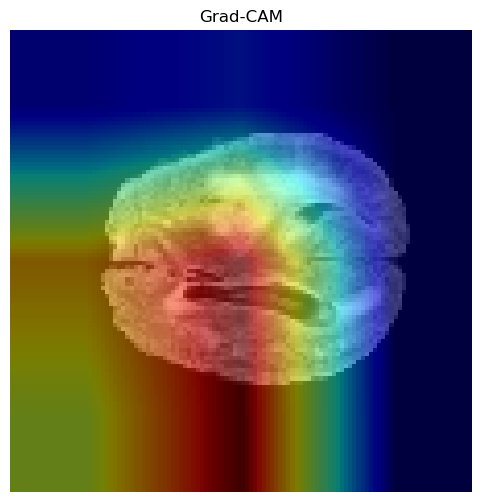

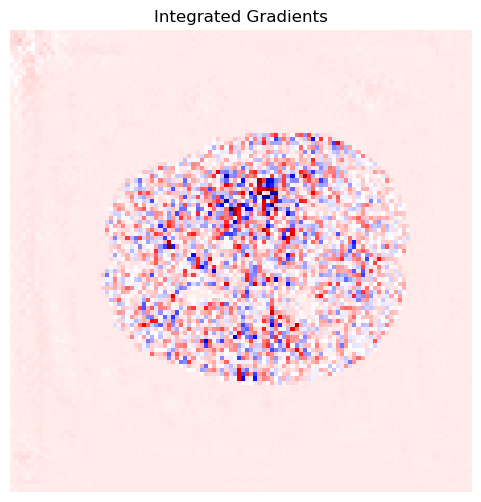

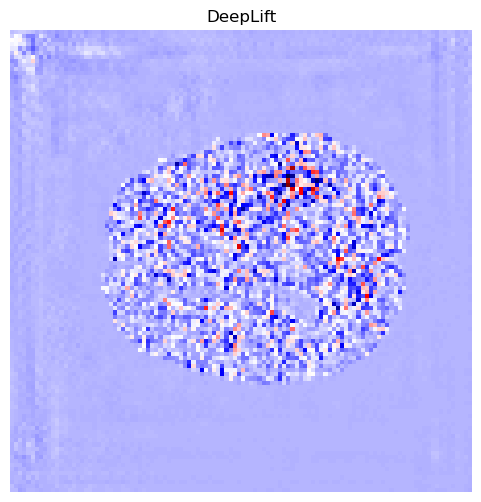

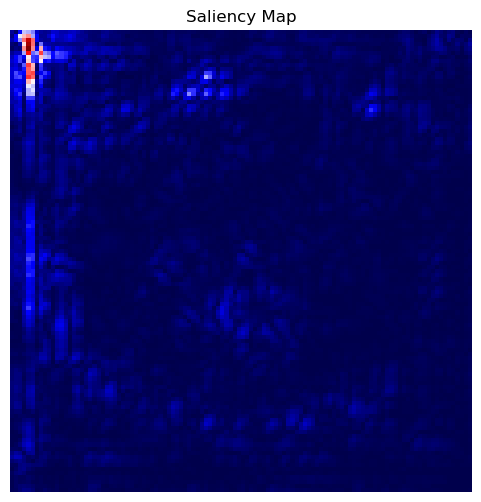

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.imshow(test_image.detach().cpu().numpy()[0, 0], cmap='gray')
plt.imshow(cam_output, cmap='jet', alpha=0.5)
plt.title('Grad-CAM')
plt.axis('off')
plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(ig_output.squeeze(), cmap='seismic')
plt.title('Integrated Gradients')
plt.axis('off')
plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(deeplift_output.squeeze(), cmap='seismic')
plt.title('DeepLift')
plt.axis('off')
plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(saliency_output.squeeze(), cmap='seismic')
plt.title('Saliency Map')
plt.axis('off')
plt.show()
